# COVID-19 CANADA Daily Stats by Province
    data from 'https://api.apify.com/v2/datasets/ji95MgtBVgGJF7XcP/items?format=json&clean=1'

In [93]:
import pandas as pd 
import numpy as np
import datetime
import json
import urllib
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

covid_url = 'https://api.apify.com/v2/datasets/ji95MgtBVgGJF7XcP/items?format=json&clean=1'

def inttodate(date_in,mode='date'):
    #yyyymmdd
    date_int = int(date_in)
    year = int(np.floor(date_int/10000))
    month = int(np.floor((date_int - year*10000)/100))
    day = int(date_int - year*10000 - month*100)
    
    if mode =='date':
        date = datetime.date(year,month,day)
    elif mode == ' datetime':
        date = datetime.datetime(year,month,day,0,0,0)
    elif mode == 'np.datetime64':
        date=np.datetime64(datetime.datetime(year,month,day))
    return date

def covidJsonToDf(json_in,sma_window=5,verbose=False):
    data = json_in.copy()
    df = []
    cols=['Date']
    if verbose:
        print("len=",len(data))
    for i in range(len(data)):
        if verbose:
            print(" i=",i)
        this_row = []
        date=data[i]['lastUpdatedAtApify']
        if verbose:
            print(" date=",date)
        prov_array=data[i]['infectedByRegion']
        if verbose:
            print(" prov_array=",prov_array)
        for j in range(len(prov_array)):
            if verbose:
                print("   j=",j)
            vals=[date]
            cell_j=prov_array[j]
            for field in cell_j:
                if i==0 and j==0:
                    if verbose:
                        print("     field=",field)
                    cols.append(field)
                vals.append(cell_j[field])
                if verbose:
                    print("     value=",cell_j[field])
            df.append(vals)
            if verbose:
                print("   cols=",cols)
                print("   vals=",vals)  
            

    df=pd.DataFrame(df)
    df.columns=list(cols)
    
    return df
    
def calcFields(df,sma_window=5,verbose=False):
    df['Datetime']=df['Date'].apply(lambda d: np.datetime64(d))
    df['Date']=df['Datetime'].apply(lambda dt: dt.date())
    df=df.drop_duplicates(subset=['region','Date'],keep='last').reset_index(drop=True)
    del df['Datetime']
    df['infectedCount']=pd.to_numeric(df['infectedCount'],errors='coerce')
    df['deceasedCount']=pd.to_numeric(df['deceasedCount'],errors='coerce')
    df=df.sort_values(by=['region','Date'])
    df['lagInfected']=df.groupby('region').shift(1)['infectedCount']
    df['lagDeceased']=df.groupby('region').shift(1)['deceasedCount']
    df['newInfected']=df['infectedCount']-df['lagInfected']
    df['newDeceased']=df['deceasedCount']-df['lagDeceased']
    
    
    #df['deathRate']=df['deceasedCount']/df['infectedCount']
    #df=df.sort_values(by=['region','Date'])
    
    df['SMA_newInfected_'+str(sma_window)] = df['newInfected'].rolling(window=sma_window).mean()
    df['SMA_newDeceased_'+str(sma_window)] = df['newDeceased'].rolling(window=sma_window).mean()
        
    return df



print('-- setup and functions')

-- setup and functions


In [94]:
dfpop = pd.read_csv('~/Documents/COVID/us_state_population.csv')

response = urllib.request.urlopen(covid_url)
data = json.loads(response.read())

df = covidJsonToDf(data,verbose=False)

df=calcFields(df)
max_date = max(df['Date'])
df_today=df[df['Date']==max_date].reset_index(drop=True)

print('Data As Of: ',max_date)

Data As Of:  2020-05-04


C:\Users\justi\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [95]:
df.head()

,Date,region,infectedCount,deceasedCount,lagInfected,lagDeceased,newInfected,newDeceased,SMA_newInfected_5,SMA_newDeceased_5
9,2020-03-29,Alberta,621,2.0,NaN,NaN,NaN,NaN,NaN,NaN
24,2020-03-30,Alberta,690,8.0,621.0,2.0,69.0,6.0,NaN,NaN
39,2020-03-31,Alberta,754,9.0,690.0,8.0,64.0,1.0,NaN,NaN
54,2020-04-01,Alberta,754,9.0,754.0,9.0,0.0,0.0,NaN,NaN
69,2020-04-02,Alberta,871,13.0,754.0,9.0,117.0,4.0,NaN,NaN


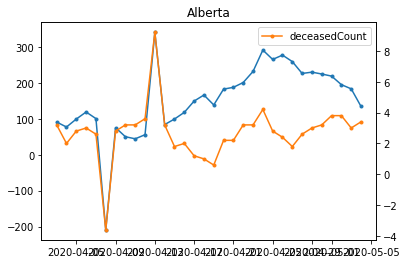

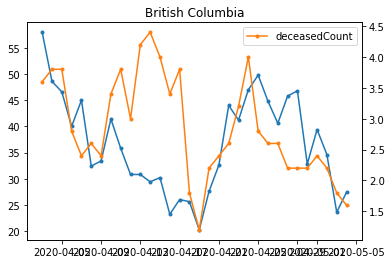

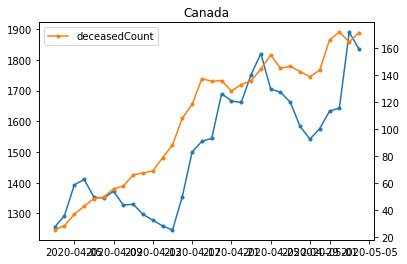

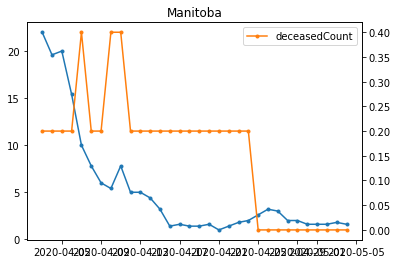

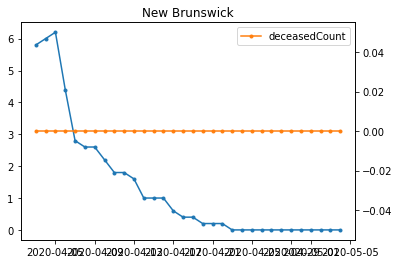

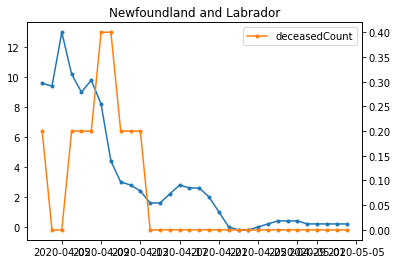

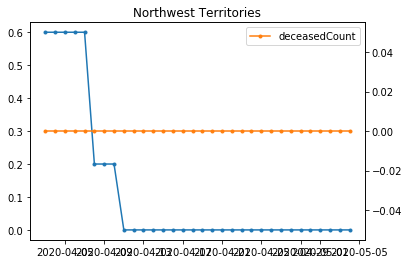

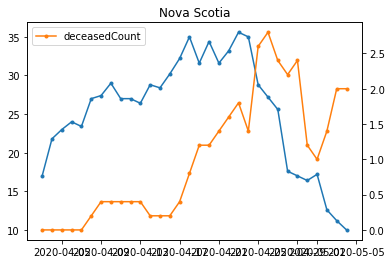

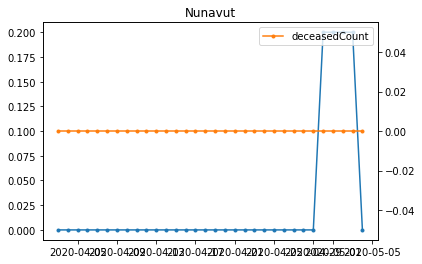

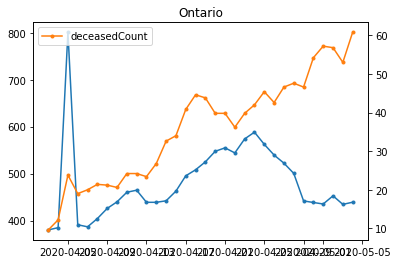

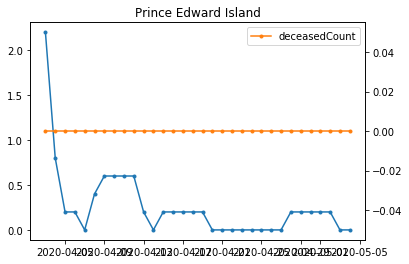

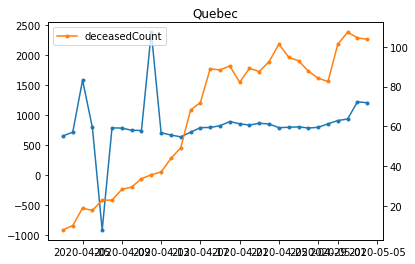

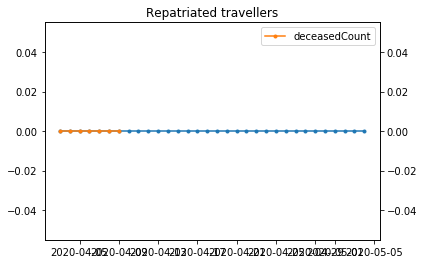

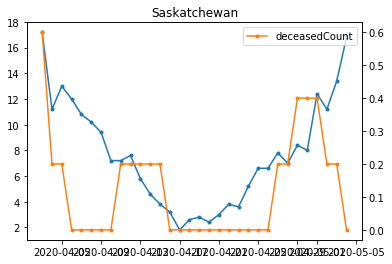

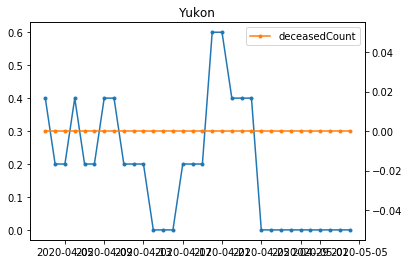

In [96]:
for region in df['region'].unique():
    df_region=df[df['region']==region]
    try:
        fig,ax1=plt.subplots()
        ax2=ax1.twinx()
        ax1.plot(df_region['Date'],df_region['SMA_newInfected_5'],'.-',label='infectedCount',color='C0')
        ax2.plot(df_region['Date'],df_region['SMA_newDeceased_5'],'.-',label='deceasedCount',color='C1')
        plt.title(region)
        plt.legend()
    except:()
plt.legend()